# ESG Metric Extraction

## Structure

### 1. AAPL

1.1 Imports    
1.2 Data Extraction      
1.3 Prompt Definition     
1.4 Response Retrieval     

### 2. Pipeline 
2.1 Using all PDFs     
2.2 Metric      
2.3 LLM Approach      


## 1.AAPL

### 1.1 Imports:

_from google import genai_:    
For this we are going to use Google's Gemini as our LLM for the heavy lifting.    

_from langchain.prompts import PromptTemplate_:   
We once again use langchain and its prompt template to make an instruction set for the LLM 

_import fitz_:    
For the document instruction we use the PyMuPDF also know as fitz. It will do most of the preprocessing from pdf loading to text extraction.



In [1]:
import os
import sys
sys.path.append('..')

from google import genai
from langchain.prompts import PromptTemplate
import fitz  # PyMuPDF


#### File path:
Currently in this repository it is find in _data/raw/ESG_ folder

In [2]:
ticker_name = 'AAPL'
file_path = f'../data/raw/ESG/{ticker_name}.pdf'

### 1.2 Data Extraction

This function extracts the text from the pdf file. It filters the document for header and footers to not use any uncessary tokens on the LLM. 

In [3]:
def extract_pdf_text(doc_path, margin_height=50):
    doc = fitz.open(doc_path)
    all_text = []

    for page in doc:
        page_height = page.rect.height
        blocks = page.get_text("dict")["blocks"]

        for block in blocks:
            if "lines" not in block:
                continue
            for line in block["lines"]:
                for span in line["spans"]:
                    text = span["text"].strip()
                    y0, y1 = span["bbox"][1], span["bbox"][3]

                    # Skip if within header/footer margin
                    if y1 < margin_height or y0 > (page_height - margin_height):
                        continue

                    all_text.append(text)

    return "\n".join(all_text)

pdf_text = extract_pdf_text(file_path)

### 1.3 Prompt Definition.
With larger Models like Gemini and ChatGPT, the prompt has a siginificant impact on the output. 
These prompts are highly configurable and designable to your goals.

In this case we want the model to pull all the data that may in any way be a metric related to ESG from the document.    
To measure this we require it to return the unit in ISO format so that the different profiles comparable later on.    
Lastly we want it to return it in JSON format so it is easily manipulatable and useful for saving and loading.

In [4]:
prompt = PromptTemplate(
    input_variables=["document_text"],
    template="""You are an expert in environmental, social, and governance (ESG) data extraction and reporting.

            Your task is to carefully extract **all relevant ESG metrics** from the following report text. 
            These include, but are not limited to: emissions (Scopes 1, 2, 3), energy usage, water usage, waste, recycled materials, carbon footprint, renewable energy deployment, and any target/goal progression. 
            Please include all the data from previous years as well.

            Please:

            1. Structure the output as **valid JSON**.
            2. Include **all available years** for each metric (not just the current year).
            3. Make sure to take a look at and for **tables**. Some data may be in tabular format and structured as such.
            4. Use **standardized ISO units** where possible (e.g., metric tons of CO2e, MWh, gallons, percentages). Convert if necessary.
            5. Use **clear and consistent keys**, and group metrics by category such as "Emissions", "Energy", "Water", "Materials", "Waste", etc.
            6. Omit interpretation — just provide structured data as precisely as stated in the document.

            Here is the report text:

            --- START OF REPORT TEXT ---

            {document_text}

            --- END OF REPORT TEXT ---

            Ensure the output is JSON-serializable and can be parsed using json.loads() in Python:
            Make sure to include to include the company name and ticker in the output JSON.
            The company name is Apple Inc. and the ticker is AAPL.
            Please provide the output in the following format where the hierachy is "Category > Subcategory > Year > Metric and value" like the following:

            "DesignAndMaterials":{{
                "RecycledGoldIncrease": {{
                    "2021": {{
                        "value": 1,
                        "unit": "%"
                    }},
                }}
            }}

            Output Requirements:
            - Use matching brackets ({{}}, [ ]).
            - Do not include trailing commas before closing brackets or braces.
            - All keys must be quoted like this: "key": value.
            - Use objects ({{}}) for key-value pairs.
            - Output only raw JSON — no comments or explanation.

            Use this format to structure the response:
            {{ 
            "example": [1, 2, 3] 
            }}

            Now return the extracted ESG metrics in valid JSON format:
        
            """
)

### 1.4 Response Retrieval

This is the model definition as per the Google API. For this you will require an API Key that you can get [here](https://aistudio.google.com/apikey).    
The model will output a class called _GenerateContentResponse_ that contains metadata and the actually text at output.text.

Since its output is json it will output a markdown format preceded by \`\`\`json and succeded by \`\`\` which we filter out.

The rest is then in nice json format that we use for our metric. This will be done in a different document though. 


In [5]:
client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])

In [6]:
json_response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=prompt.format(document_text=pdf_text),
)
output_text = json_response.text.replace("```json", "").replace("```", "")


### 1.5 Saving the Data

After we received the output text we need to make sure we can saved it to a json file, since this is the filetype we are going to be going with.
For this we will be using _json5_ as a tolerant json laoder and _ast_ as our string to json converter.

In [7]:
import json5
import json
import ast
clean_json_string = ast.literal_eval(f"'''{output_text}'''")
parsed_json = json5.loads(clean_json_string)

In [8]:
with open(f"../data/processed/ESG/{ticker_name}.json", "w") as json_file:
    json.dump(parsed_json, json_file, indent=4)

## 2. Full Pipeline with Evaluation Metric

For ease of viewing, the previous steps have been summarize in the _GeminiPipeline_ class that has all the key steps but also iterates through all the files and not just one. 

## 2.1 Using all pdfs

In [9]:
from src.common.gemini_pipeline import GeminiPipeline
import sys
sys.path.append('..')


In [10]:
pipeline = GeminiPipeline(prompt_template=prompt, source_path='../data/raw/ESG', target_path='../data/processed/ESG')

In [11]:
pipeline.run()

  0%|          | 0/9 [00:00<?, ?it/s]

../data/raw/ESG/GOOG.pdf
Error: <string>:196 Unexpected """ at column 6
Retrying...


 11%|█         | 1/9 [00:35<04:42, 35.33s/it]

../data/raw/ESG/Sustainability Statement 2024.pdf


 22%|██▏       | 2/9 [00:48<02:36, 22.35s/it]

../data/raw/ESG/.DS_Store
../data/raw/ESG/AAPL.pdf


 44%|████▍     | 4/9 [01:01<01:02, 12.42s/it]

../data/raw/ESG/broadcom-2024-corporate-responsibility-final.pdf


 56%|█████▌    | 5/9 [01:22<01:00, 15.03s/it]

../data/raw/ESG/2024-sustainability-report-en.pdf


 67%|██████▋   | 6/9 [01:33<00:41, 13.91s/it]

../data/raw/ESG/NVDA.pdf


 78%|███████▊  | 7/9 [02:09<00:41, 20.62s/it]

../data/raw/ESG/sustainability-report-2024.pdf


 89%|████████▉ | 8/9 [02:18<00:16, 16.93s/it]

../data/raw/ESG/Microsoft-2024-Environmental-Sustainability-Report.pdf


100%|██████████| 9/9 [02:29<00:00, 16.65s/it]


## 2.2 Metric

To compare the different Company reports we need to define a rubric to compare. For this you choose arbitrary metrics the following is just one example:    
- For this we want to take into account the emissions performance, more specifcally how well a company does in decarbonizing its operations.   
- The second aspect is they're effort of using renewables and clean energy. 
- The third aspect should touch on recycling efforts and the last aspect is their robustness in these policies.   

### 1. Emissions Performance
**Goal:** Evaluate decarbonization effort and results.  
**Inputs:**
- Percent reduction in GHG emissions from a baseline year  
- Carbon neutrality status or timeline  
- Trend in total emissions (if percent reduction unavailable)

**Scoring Criteria:**

| Score | Description |
|-------|-------------|
| **5** | 60 percent or more emissions reduction or already carbon neutral |
| **4** | 40–59 percent reduction and clear trajectory to carbon neutrality |
| **3** | 20–39 percent reduction or mid-term carbon neutrality goal (e.g., 2035) |
| **2** | Some reductions claimed but not quantified |
| **1** | Emissions increasing or unclear trajectory |
| **0** | No emissions data provided |

### 2. Clean Energy Commitment
**Goal:** Assess use of and commitment to renewable/carbon-free energy.  
**Inputs:**
- Percent renewable or carbon-free energy in operations or data centers  
- 24/7 carbon-free energy (CFE) goals or equivalent  
- Supplier clean energy initiatives

**Scoring Criteria:**

| Score | Description |
|-------|-------------|
| **5** | 100 percent renewable energy currently or achieved 24/7 CFE in key regions |
| **4** | 80–99 percent renewable/CFE or strong 24/7 CFE roadmap |
| **3** | 50–79 percent renewable or clear target by 2030 |
| **2** | Some clean energy use with future intent |
| **1** | Minimal renewable usage or weak targets |
| **0** | No data |

### 3. Circularity & Material Use
**Goal:** Evaluate use of recycled/renewable materials and sustainable design.  
**Inputs:**
- Percent recycled content in products  
- Percent plastic-free or recyclable packaging  
- Design for repairability and product longevity

**Scoring Criteria:**

| Score | Description |
|-------|-------------|
| **5** | 75 percent or more recycled materials or 100 percent plastic-free packaging |
| **4** | 50–74 percent recycled materials or major product lines plastic-free |
| **3** | Moderate recycled content and/or some repairability features |
| **2** | Minimal recycling efforts, vague goals |
| **1** | Occasional mentions without targets or progress |
| **0** | No relevant data |

### 4. ESG Governance & Supply Chain Engagement
**Goal:** Measure maturity of ESG policy, certifications, and supplier practices.  
**Inputs:**
- Supplier audits and sustainability criteria  
- ESG integration in board, code of conduct, or strategy  
- Reporting (e.g., TCFD, SASB, ISO certifications)

**Scoring Criteria:**

| Score | Description |
|-------|-------------|
| **5** | Strong supplier requirements, verified audits, and third-party certifications |
| **4** | Supplier engagement plus ESG board integration or public policy commitments |
| **3** | Some supplier metrics or ESG frameworks used |
| **2** | Mentions of governance, but no metrics or enforcement |
| **1** | Weak or indirect references |
| **0** | No ESG governance data |


## 2.3 LLM approach:

In [12]:
prompt_metric = PromptTemplate(input_variables=["document_text"],
                template= """ 
                You are an ESG Score Evaluator.
                Your task is to evaluate the ESG score of a company based on the extracted ESG metrics from the following report text.
                
                The rubric for the evaluation is as follows:

                1. Emissions Performance
                Goal: Evaluate decarbonization effort and results.
                Inputs:
                    - Percent reduction in GHG emissions from a baseline year
                    - Carbon neutrality status or timeline
                    - Trend in total emissions (if percent reduction unavailable)
                Scoring:
                    5 = 60 percent or more emissions reduction or already carbon neutral
                    4 = 40–59 percent reduction and clear trajectory to carbon neutrality
                    3 = 20–39 percent reduction or mid-term carbon neutrality goal (e.g., 2035)
                    2 = Some reductions claimed but not quantified
                    1 = Emissions increasing or unclear trajectory
                    0 = No emissions data provided

                2. Clean Energy Commitment
                Goal: Assess use of and commitment to renewable/carbon-free energy.
                Inputs:
                    - Percent renewable or carbon-free energy in operations or data centers
                    - 24/7 carbon-free energy (CFE) goals or equivalent
                    - Supplier clean energy initiatives
                Scoring:
                    5 = 100 percent renewable energy currently or achieved 24/7 CFE in key regions
                    4 = 80–99 percent renewable/CFE or strong 24/7 CFE roadmap
                    3 = 50–79 percent renewable or clear target by 2030
                    2 = Some clean energy use with future intent
                    1 = Minimal renewable usage or weak targets
                    0 = No data

                3. Circularity & Material Use
                Goal: Evaluate use of recycled/renewable materials and sustainable design.
                Inputs:
                    - Percent recycled content in products
                    - Percent plastic-free or recyclable packaging
                    - Design for repairability and product longevity
                Scoring:
                    5 = 75 percent or more recycled materials or 100 percent plastic-free packaging
                    4 = 50–74 percent recycled materials or major product lines plastic-free
                    3 = Moderate recycled content and/or some repairability features
                    2 = Minimal recycling efforts, vague goals
                    1 = Occasional mentions without targets or progress
                    0 = No relevant data

                4. ESG Governance & Supply Chain Engagement
                Goal: Measure maturity of ESG policy, certifications, and supplier practices.
                Inputs:
                    - Supplier audits and sustainability criteria
                    - ESG integration in board, code of conduct, or strategy
                    - Reporting (e.g., TCFD, SASB, ISO certifications)
                Scoring:
                    5 = Strong supplier requirements, verified audits, and third-party certifications
                    4 = Supplier engagement plus ESG board integration or public policy commitments
                    3 = Some supplier metrics or ESG frameworks used
                    2 = Mentions of governance, but no metrics or enforcement
                    1 = Weak or indirect references
                    0 = No ESG governance data

                Please return me the ESG score of the company based on the above rubric in valid JSON format with the following keys:
                [Company,EmissionsPerformance, CleanEnergy, Recycling, Robustness]

                Here is the report text:
                --- START OF REPORT TEXT ---

                {document_text}

                --- END OF REPORT TEXT ---
                """
                )


In [13]:
files = os.listdir('../data/processed/ESG')

output = []

for file in files:
    with open(f'../data/processed/ESG/{file}', 'r') as f:
        json_data = f.read()

    metric = pipeline.retrieve(prompt=prompt_metric.format(document_text=json_data))
    output.append(metric)

In [ ]:
### Post-processing the output
metrics_text = [metric.text.replace("```json", "").replace("```", "") for metric in output]
metrics_text = [ast.literal_eval(f"'''{text}'''") for text in metrics_text]
metrics_text = [json5.loads(text) for text in metrics_text]

### Plot: 

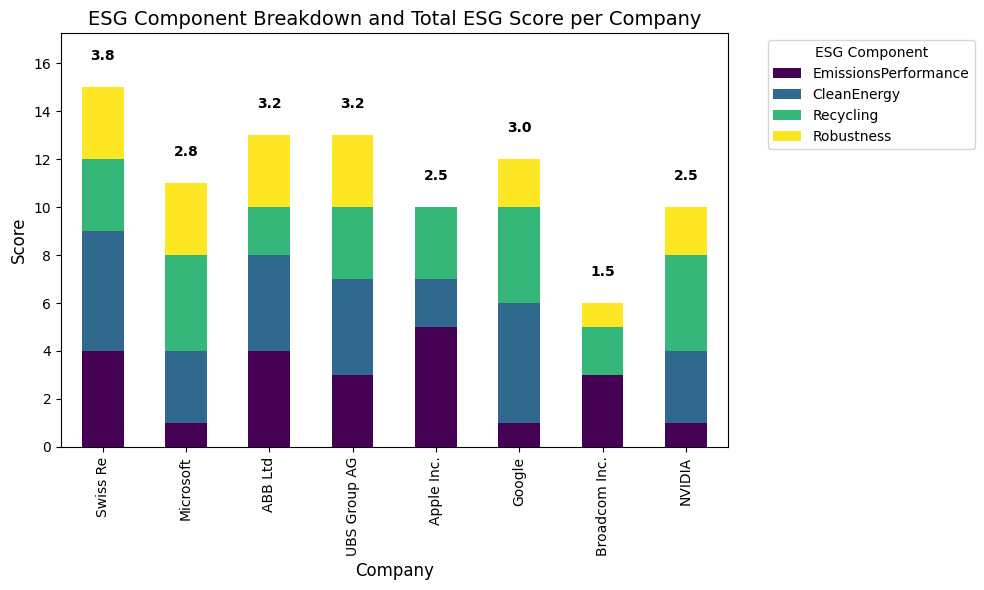

In [17]:
from src.utils.utils import plot_ESG_metric
plot_ESG_metric(metrics_text)